In [33]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
sys.path.append('/content/drive/MyDrive/flickr8k')

Mounted at /content/drive


In [34]:
import torch
import torch.nn as nn
import torchvision.models as models


class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.resnet(images)
        if self.train_CNN:
            features = self.dropout(self.relu(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]
  

In [35]:
import os
import pandas as pd
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision.transforms as transforms
import string


spacy_eng = spacy.load("en_core_web_sm")


class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        prepositions =["an","a"]#,"in", "on", "at", "to", "for", "with", "from", "by", "of", "about", "as", "into", "like", "through", "after", "over", "between", "out", "against", "during", "without", "before", "under", "around", "among", "off", "above", "near"]
        punctuation = string.punctuation
        tokens = [tok.text.lower() for tok in spacy_eng.tokenizer(text)]
        tokens = [tok for tok in tokens if tok not in prepositions and tok not in punctuation]
        return tokens

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)


class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)
        return imgs, targets


def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=64,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)
    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import matplotlib.pyplot as plt

# Hyperparameters
embed_size = 300
hidden_size = 256
num_layers = 1
learning_rate = 4e-4
num_epochs = 30
load_model = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
folder_name = "/content/drive/MyDrive/flickr8k/Images"
annotation_file = "/content/drive/MyDrive/flickr8k/captions.txt"
vocab_file = "data/vocab.pkl"
log_dir = "logs"

# Create model directory
if not os.path.exists("models"):
    os.makedirs("models")

# Load the data
transform = transforms.Compose(
    [
        transforms.Resize((356, 356)),
        transforms.RandomCrop((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
loader, dataset = get_loader(
    folder_name, annotation_file, transform=transform, batch_size=64, shuffle=True
)

# Split the dataset into train and validation parts
train_ratio = 0.9
val_ratio = 0.1
total_samples = len(dataset)
train_size = int(train_ratio * total_samples)
val_size = total_samples - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create loaders for train and validation datasets
train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=8,pin_memory=True,collate_fn=MyCollate(pad_idx=dataset.vocab.stoi["<PAD>"]),)

val_loader = DataLoader(val_dataset,batch_size=64,shuffle=False,num_workers=8,pin_memory=True,collate_fn=MyCollate(pad_idx=dataset.vocab.stoi["<PAD>"]),)

# Initialize the model
vocab_size = len(dataset.vocab)
model = CNNtoRNN(embed_size, hidden_size, num_layers).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can als

In [37]:
# Training loop
total_step = len(train_loader)
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (images, captions) in enumerate(train_loader):
        images = images.to(device)
        captions = captions.to(device)

        outputs = model(images, captions[:-1])
        loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=(loss.item())
        # Print training loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Training Loss: {loss.item()}")
    
    train_losses.append (train_loss/len(train_loader))

    # Calculate validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, captions in val_loader:
            images = images.to(device)
            captions = captions.to(device)

            outputs = model(images, captions[:-1])
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Print validation loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss}")

Streaming output truncated to the last 5000 lines.
Epoch [22/30], Step [131/569], Training Loss: 2.5171327590942383
Epoch [22/30], Step [132/569], Training Loss: 2.4827630519866943
Epoch [22/30], Step [133/569], Training Loss: 2.526196241378784
Epoch [22/30], Step [134/569], Training Loss: 2.726017475128174
Epoch [22/30], Step [135/569], Training Loss: 2.626159906387329
Epoch [22/30], Step [136/569], Training Loss: 2.6897242069244385
Epoch [22/30], Step [137/569], Training Loss: 2.4067153930664062
Epoch [22/30], Step [138/569], Training Loss: 2.372014284133911
Epoch [22/30], Step [139/569], Training Loss: 2.579843759536743
Epoch [22/30], Step [140/569], Training Loss: 2.6706643104553223
Epoch [22/30], Step [141/569], Training Loss: 2.723473072052002
Epoch [22/30], Step [142/569], Training Loss: 2.4889354705810547
Epoch [22/30], Step [143/569], Training Loss: 2.486624240875244
Epoch [22/30], Step [144/569], Training Loss: 2.6267447471618652
Epoch [22/30], Step [145/569], Training Loss: 

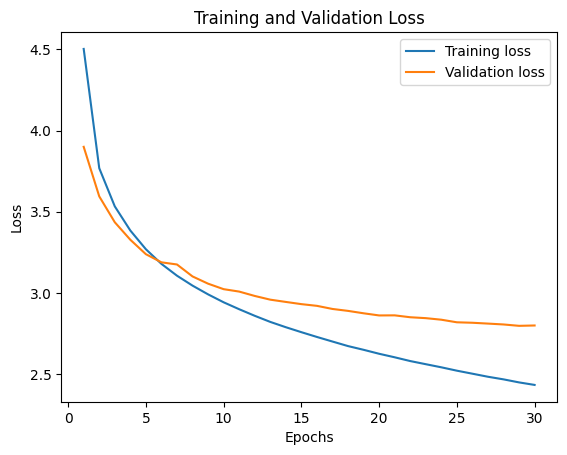

In [38]:
# Plot loss on an epoch diagram
plt.plot(range(1, num_epochs+1), train_losses, label="Training loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


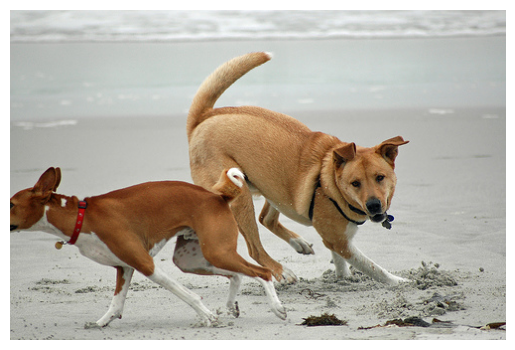

In [39]:
# Image preprocessing
image_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

image_path = "/content/drive/MyDrive/flickr8k/Images/1024138940_f1fefbdce1.jpg"

image = image_transform(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)

# Generate caption
with torch.no_grad():
    caption = model.caption_image(image, dataset.vocab)

# Display the image and caption
image = Image.open(image_path)
plt.imshow(image)
plt.axis("off")
plt.show()
print("Generated Caption:", caption)

Generated Caption: ['<SOS>', 'two', 'dogs', 'are', 'playing', 'in', 'the', 'snow', '<EOS>']


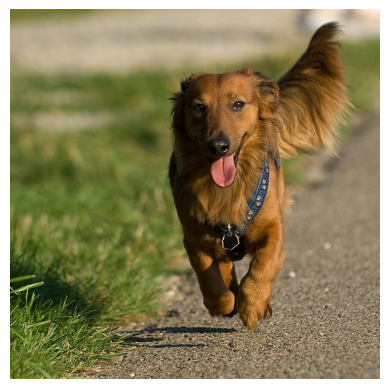

Generated Caption: ['<SOS>', 'brown', 'dog', 'is', 'running', 'through', 'the', 'grass', '<EOS>']


In [40]:
# Image preprocessing
image_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

image_path = "/content/drive/MyDrive/flickr8k/Images/1089181217_ee1167f7af.jpg"

image = image_transform(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)

# Generate caption
with torch.no_grad():
    caption = model.caption_image(image, dataset.vocab)

# Display the image and caption
image = Image.open(image_path)
plt.imshow(image)
plt.axis("off")
plt.show()
print("Generated Caption:", caption)

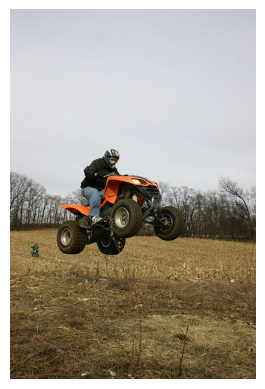

Generated Caption: ['<SOS>', 'man', 'is', 'riding', 'bike', 'through', 'the', 'woods', '<EOS>']


In [41]:
# Image preprocessing
image_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

image_path = "/content/drive/MyDrive/flickr8k/Images/109823395_6fb423a90f.jpg"

image = image_transform(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)

# Generate caption
with torch.no_grad():
    caption = model.caption_image(image, dataset.vocab)

# Display the image and caption
image = Image.open(image_path)
plt.imshow(image)
plt.axis("off")
plt.show()
print("Generated Caption:", caption)